In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

# Specify data directory
path = '/content/drive/My Drive/dataset'

Mounted at /content/drive


In [ ]:
import torch

if torch.cuda.is_available():
    tensor_gpu = tensor_random.to('cuda')

In [ ]:
from os import walk
import os
print(os.listdir(path))

for (dirpath, dirnames, filenames) in walk(path):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)

['freshbanana', 'freshokra']
Directory path:  /content/drive/My Drive/dataset
Folder name:  ['freshbanana', 'freshokra']
Directory path:  /content/drive/My Drive/dataset/freshbanana
Folder name:  []
Directory path:  /content/drive/My Drive/dataset/freshokra
Folder name:  []


In [ ]:
image_dict = {}

# Define the list of file names
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import os
# Initialize empty lists to store file names and labels
file_names = []
labels = []

for file in sorted((Path(path).glob('*/*.*'))):
    label = str(file).split('/')[-2]  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print(len(file_names), len(labels))

# Create a pandas dataframe from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

3484 3484
(3484, 2)


In [ ]:
df.head()

,image,label
0,/content/drive/My Drive/dataset/freshbanana/Sc...,freshbanana
1,/content/drive/My Drive/dataset/freshbanana/Sc...,freshbanana
2,/content/drive/My Drive/dataset/freshbanana/Sc...,freshbanana
3,/content/drive/My Drive/dataset/freshbanana/Sc...,freshbanana
4,/content/drive/My Drive/dataset/freshbanana/Sc...,freshbanana


In [ ]:
df_label=df['label'].value_counts().to_frame().reset_index()
df_label

,index,label
0,freshbanana,2849
1,freshokra,635


In [ ]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

dataset = ImageFolder(path, transform=transform)

dataset.class_to_idx

{'freshbanana': 0, 'freshokra': 1}

In [ ]:
from collections import Counter

counts = dict(Counter(dataset.targets))
counts.values()

dict_values([2849, 635])

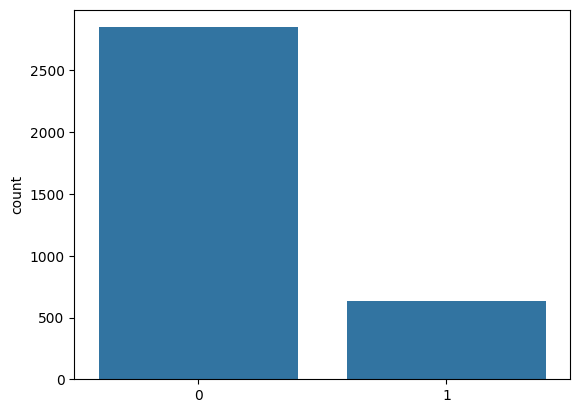

In [ ]:
#before sampling
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x = dataset.targets)
plt.show()

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))

test_size = int(0.1 * len(dataset))

val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [ ]:
print("Training set size: ", len(train_dataset))
print("Testing set size: ", len(test_dataset))
print("Validation set size: ", len(val_dataset))

Training set size:  2787
Testing set size:  348
Validation set size:  349


In [ ]:
print(dict(Counter(train_dataset.dataset.targets)))

{0: 2849, 1: 635}


In [ ]:
train_dataset.targets = torch.tensor([train_dataset.dataset.targets[i] for i in train_dataset.indices]).numpy().tolist()
train_dataset.label = torch.tensor([train_dataset.dataset.samples[i][1] for i in train_dataset.indices]).numpy().tolist()

In [ ]:
dict_ = {"fresh_banana": 0, "fresh_okra": 1}
#df['label'].unique().tolist()

class_counts = torch.tensor([train_dataset.targets.count(c) for c in [0, 1]])
print(class_counts)
print(len(class_counts))
class_weights = 1.0 / class_counts.double()
print(class_weights)

weights = [class_weights[target] for target in train_dataset.label]
#print([class_weights[dict_.get(target)] for target in df['label'].tolist()])
print(len(weights))
#print(weights)
#weights = [class_weights[target] for target in targets]
sample_weights = torch.DoubleTensor(weights)
print(sample_weights)

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

tensor([2279,  508])
2
tensor([0.0004, 0.0020], dtype=torch.float64)
2787
tensor([0.0004, 0.0004, 0.0020,  ..., 0.0004, 0.0020, 0.0004],
       dtype=torch.float64)


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler = sampler, batch_size = 64, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, num_workers=2)

In [ ]:
from torchvision import models

model=models.vgg16(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import torch.nn as nn
num_classes = 2
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(512, num_classes))

In [ ]:
model.named_parameters

<bound method Module.named_parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Sequential(
      (0): Linear(in_features=4096, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=512, out_features=2, bias=True)
    )
  )
)>

In [ ]:
import torch
import torch.optim as optim

# adding loss_fn and optimizer to the model
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

# Decay LR by a factor of 0.1 every 3 epochs
#exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [ ]:
from tqdm.notebook import tqdm_notebook

def train(model,num_epochs,train_dl,valid_dl,train_data_percent,model_name):
    model.to(device)   # to run on GPU
    max_acc=0.0
    torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
    loss_hist_train=[0]*num_epochs
    accuracy_hist_train=[0]*num_epochs
    loss_hist_valid=[0]*num_epochs
    accuracy_hist_valid=[0]*num_epochs
    no_of_batches_to_train=int(round(len(train_dl)*train_data_percent))
    for epoch in tqdm_notebook(range(num_epochs),desc="Number of Epochs Completed"):
        model.train()
        count=0
        for x_batch,y_batch in tqdm_notebook(train_dl,desc="Number of Training Batches Completed"):
            if train_data_percent!=1 and count>no_of_batches_to_train:
                break
            count+=1
            x_batch,y_batch=x_batch.to(device),y_batch.to(device)
            pred=model(x_batch)
            loss=loss_fn(pred,y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch]+=loss.item()*y_batch.size(0)
            is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
            accuracy_hist_train[epoch]+=is_correct.sum()
        loss_hist_train[epoch]/=len(train_dl.dataset)
        accuracy_hist_train[epoch]/=len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch,y_batch in tqdm_notebook(valid_dl,desc="Number of Validation Batches Completed"):
                x_batch,y_batch=x_batch.to(device),y_batch.to(device)
                pred=model(x_batch)
                loss=loss_fn(pred,y_batch)
                loss_hist_valid[epoch]+=loss.item()*y_batch.size(0)
                is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
                accuracy_hist_valid[epoch]+=is_correct.sum()
            loss_hist_valid[epoch]/=len(valid_dl.dataset)
            accuracy_hist_valid[epoch]/=len(valid_dl.dataset)
       # lr_scheduler.step()
        if accuracy_hist_valid[epoch]>max_acc:
            max_acc=accuracy_hist_valid[epoch]
            torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
        print(f'Epoch {epoch+1} accuracy: '
               f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
               f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid



In [ ]:
num_epochs=10
hist=train(model,num_epochs,train_dataloader,val_dataloader,0.2,"model_vgg")

Number of Epochs Completed:   0%|          | 0/10 [00:00<?, ?it/s]

Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 accuracy: 0.1109 val_accuracy: 0.8252


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 accuracy: 0.1148 val_accuracy: 0.1748


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 accuracy: 0.1127 val_accuracy: 0.1748


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 accuracy: 0.1188 val_accuracy: 0.1748


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 accuracy: 0.1163 val_accuracy: 0.8252


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 accuracy: 0.1123 val_accuracy: 0.1748


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 accuracy: 0.1091 val_accuracy: 0.1748


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 accuracy: 0.1051 val_accuracy: 0.1748


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 accuracy: 0.1123 val_accuracy: 0.1748


Number of Training Batches Completed:   0%|          | 0/44 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 accuracy: 0.1062 val_accuracy: 0.8252


In [ ]:
import pickle

with open('model_vgg_medium.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Test the model
y_true, y_pred = test_model(model, test_dataloader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[282   0]
 [ 66   0]]


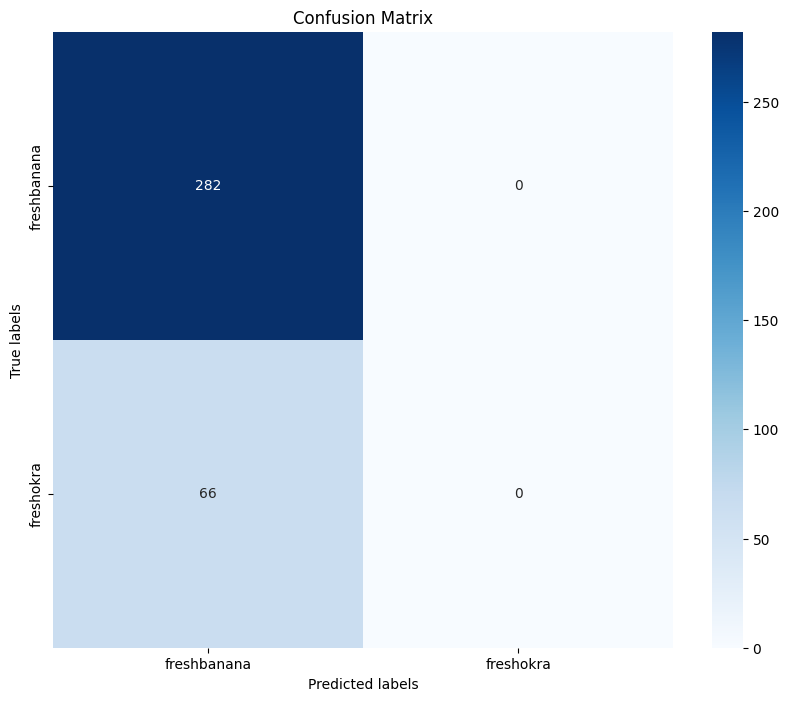

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
train_accuracies = []
test_accuracies = []
for i in range(len(hist[2])):
    if device.type == 'cuda':
      train_accuracies.append(hist[2][i].cpu().numpy().tolist())
      test_accuracies.append(hist[3][i].cpu().numpy().tolist())
    else:
      train_accuracies.append(hist[2][i].numpy().tolist())
      test_accuracies.append(hist[3][i].numpy().tolist())